In [1]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
from timeit import default_timer as timer
import benchmark_functions as bf

In [2]:
class MetricCollector:
    def __init__(self, name: str = None, run_id: int = None):
        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []
        self.name = name
        self.run_id = run_id
        self.iter_reached_vtr = -1
        self.nfev = -1
        self.time = -1

    def collect_once(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_vtr(self, i, nfev, time):
        self.iter_reached_vtr = i
        self.nfev = nfev
        self.time = time

    def compile_graph(self):
        plt.plot(self.best_individual_cost_each_gen, label="Best Individual Fitness")
        plt.plot(self.avg_cost_each_gen, label="Average Fitness")
        plt.yscale("log")
        plt.legend()

        path = f"results/de/{self.name}/"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(f"{path}cost.npy", self.best_individual_cost_each_gen)
        plt.savefig(f"{path}graph.png")

    def save_results(self):
        path = f"results/de/{self.name}/{self.run_id}.txt"

        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            f.write(f"{self.best_individual_cost_each_gen[-1]}\n")
            f.write(f"{self.iter_reached_vtr}\n")
            f.write(f"{self.nfev}\n")
            f.write(f"{self.time}\n")

In [3]:
def check_bounds(
    x: np.ndarray,
    bounds: List[Tuple]
):
    x_copy = copy.deepcopy(x)
    for i in range(len(x)):
        if x[i] < bounds[i][0]:
            x_copy[i] = bounds[i][0]
        elif x[i] > bounds[i][1]:
            x_copy[i] = bounds[i][1]
    return x_copy

In [6]:
def differential_evolution(
    f: Callable,
    initial_pop: np.ndarray,
    differential_factor: float,
    bounds: List[Tuple],
    crossover_prob: float,
    mutator: Callable[[np.ndarray, float, int], (np.ndarray, np.ndarray)],
    crossover_func: Callable[[np.ndarray, np.ndarray, float], np.ndarray],
    population_size: int,
    n_iter: int,
    vtr: float = 10e-8,
    metric: MetricCollector = MetricCollector()
):
    """
    :param f:
        Function to be optimized
    :param initial_pop:
        Initial population
    :param differential_factor:
        Differential factor
    :param crossover_prob:
        Crossover probability
    :param mutator:
        Mutation Function to be applied to the population
        Takes in the vector to be mutated, population, differential factor and the function to be optimized
    :param crossover_func:
        Crossover function to be applied to the population
        Takes in the target vector, the mutant vector, and the crossover probability
    :param selection_func:
        Selection function to be applied to the population
        Takes in the population, offspring, population_size, and the function to be optimized
    :param population_size:
        Population size
    :param n_iter:
        Number of iterations
    :return:
        The best individual
    """
    nfev = 0
    collected_vtr = False

    start = timer()

    def f_stub(x: np.ndarray):
        nonlocal nfev
        nfev += 1
        return f(x)

    population = initial_pop.copy()
    population_val = np.apply_along_axis(f_stub, 1, population)

    initial_min_ind = np.argmin(population_val)
    population[0], population[initial_min_ind] = population[initial_min_ind], population[0]
    population_val[0], population_val[initial_min_ind] = population_val[initial_min_ind], population_val[0]

    for i in range(n_iter):
        if i % 50 == 0:
            print(f"Iteration {i}: {population_val[0]}")

        for j in range(population_size):
            target_vector, mutant_vector = mutator(population, differential_factor, j)
            crossover = crossover_func(target_vector, mutant_vector, crossover_prob)

            offspring = check_bounds(crossover, bounds)

            offspring_val = f_stub(offspring)

            if offspring_val < population_val[j]:
                population[j] = offspring
                population_val[j] = offspring_val

                if population_val[j] < population_val[0]:
                    population[0], population[j] = population[j], population[0]
                    population_val[0], population_val[j] = population_val[j], population_val[0]

        metric.collect_once(population_val[0], np.mean(population_val))

        if population_val[0] < vtr and not collected_vtr:
            end = timer()
            collected_vtr = True
            metric.collect_vtr(i, nfev, end - start)

    if population_val[0] > vtr:
        end = timer()
        metric.collect_vtr(n_iter, nfev, end - start)

    best = population[np.argmin(np.apply_along_axis(f_stub, 1, population))]
    best_val = f_stub(best)

    return best, best_val

In [7]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

def best_1_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    j, k = 0, 0
    while j == 0:
        j = np.random.randint(0, population.shape[0])
    while k == 0 or k == j:
        k = np.random.randint(0, population.shape[0])
    mutant_vector = population[0] + differential_factor * (population[j] - population[k])
    return population[i], mutant_vector

def rand_1_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    # select three indices from the population that is not equal to i
    j, k, l = 0, 0, 0
    while j == i:
        j = np.random.randint(0, population.shape[0])
    while k == i or k == j:
        k = np.random.randint(0, population.shape[0])
    while l == i or l == j or l == k:
        l = np.random.randint(0, population.shape[0])
    target_vector = population[i]
    mutant_vector = population[j] + differential_factor * (population[k] - population[l])
    return target_vector, mutant_vector

def rand_2_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    i: int
):
    j, k, l, m = np.random.choice(population.shape[0], 4, replace=False)
    target_vector = population[i]
    mutant_vector = population[i] + differential_factor * (population[j] - population[k] + population[l] - population[m])
    return target_vector, mutant_vector

def best_2_bin_mutator(
    population: np.ndarray,
    differential_factor: float,
    f: Callable
):
    i, j, k = np.random.choice(population.shape[0], 3, replace=False)
    best_vec_in_pop = population[np.argmin(np.apply_along_axis(f, 1, population))]
    target_vector = best_vec_in_pop
    mutant_vector = population[i] + differential_factor * (population[j] - population[k])
    return target_vector, mutant_vector

def binomial_crossover(
    target_vector: np.ndarray,
    mutant_vector: np.ndarray,
    crossover_prob: float
):
    trial = np.copy(target_vector)
    fill_point = np.random.randint(0, target_vector.shape[0])
    crossovers = np.random.uniform(size=target_vector.shape)
    crossovers = crossovers < crossover_prob
    crossovers[fill_point] = True
    trial = np.where(crossovers, mutant_vector, trial)
    return trial

def elitist_selection(
    population: np.ndarray,
    offspring: np.ndarray,
    population_size: int,
    f: Callable
):
    new_population_cost = np.zeros(shape=(population_size, population.shape[1]))
    new_population = np.zeros_like(population)
    for i in range(population_size):
        off_cost = f(offspring[i])
        pop_cost = f(population[i])
        if off_cost < pop_cost:
            new_population[i] = offspring[i]
            new_population_cost[i] = off_cost
        else:
            new_population[i] = population[i]
            new_population_cost[i] = pop_cost
    return new_population, new_population_cost

def latin(d: int, bounds):
    return lambda x: latin_hyper_cube_initializer(d, x, bounds, 0)

Iteration 0: 65660.2504606203
Iteration 50: 5327.850802455035
Iteration 100: 288.5465036587272
Iteration 150: 16.111619660752098
Iteration 200: 0.8720034141168331
Iteration 250: 0.06165916132161414
Iteration 300: 0.003659502443175739
Iteration 350: 0.0002076700314652257
Iteration 400: 1.0993170211648552e-05
Iteration 450: 7.439601589898657e-07
Iteration 500: 4.80909775461582e-08
Iteration 550: 3.325917242037287e-09
Iteration 600: 1.655015240827787e-10
Iteration 650: 7.693253683314404e-12
Iteration 700: 5.654708430986333e-13
Iteration 750: 2.880115850663039e-14
Iteration 800: 1.619209469583469e-15
Iteration 850: 1.0433132857404877e-16
Iteration 900: 3.630664084712012e-18
Iteration 950: 3.1148034413871685e-19


(array([-1.01642045e-11,  3.22309596e-11, -1.63261364e-11,  4.13930922e-11,
         4.13568086e-12, -4.98404572e-11,  1.30205673e-11, -3.29203486e-12,
        -1.35486730e-12, -1.38150044e-12,  1.07776930e-11,  1.99767561e-11,
         2.91620719e-11, -2.08545944e-11,  2.69060062e-11,  2.31883496e-11,
        -2.60030277e-11, -2.34130953e-12,  1.09147300e-11,  3.17706781e-11,
         2.79019092e-11,  3.76761624e-11,  1.83866595e-12,  1.27702577e-11,
        -6.54173783e-13,  1.23539013e-11, -3.07278944e-11,  2.88219411e-11,
        -2.77959875e-11, -2.40646727e-11]),
 1.6323867658895686e-20)

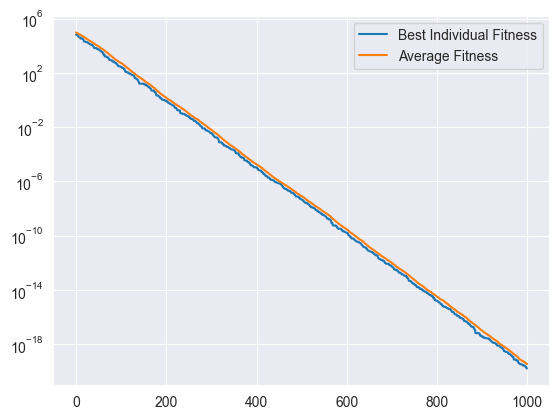

In [9]:
def sphere(x: np.ndarray):
    return np.sum(np.apply_along_axis(lambda y: y**2, 0, x))

for i in range(1):
    np.random.seed(30)
    metric_1 = MetricCollector(name="sphere", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000

    res = differential_evolution(
        f=sphere,
        differential_factor=0.5,
        bounds=bounds,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_1,
        mutator=rand_1_bin_mutator,
        population_size=40,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0)
    )

metric_1.compile_graph()
res

Iteration 0: 967450.9299453411
Iteration 50: 43792.94192557523
Iteration 100: 2928.3276425806303
Iteration 150: 193.05182711519717
Iteration 200: 12.687402337649596
Iteration 250: 0.6259772519116052
Iteration 300: 0.040602663265829765
Iteration 350: 0.002450015028024987
Iteration 400: 0.00013154590382575992
Iteration 450: 7.912778808317934e-06
Iteration 500: 4.250621939648686e-07
Iteration 550: 2.9397281694080517e-08
Iteration 600: 2.2884500991345572e-09
Iteration 650: 1.1562383765101201e-10
Iteration 700: 6.644799384069939e-12
Iteration 750: 5.892723952545319e-13
Iteration 800: 2.279084157890176e-14
Iteration 850: 1.588581923365899e-15
Iteration 900: 9.447782267019352e-17
Iteration 950: 6.8148909381964586e-18
Iteration 0: 967450.9299453411
Iteration 50: 89129.99768294285
Iteration 100: 3713.8817587079157
Iteration 150: 250.17936777219296
Iteration 200: 10.351826203002961
Iteration 250: 0.725242109877404
Iteration 300: 0.027499834600577592
Iteration 350: 0.0016609420137422082
Iteration

(array([ 1.37590483e-10,  2.20124383e-12,  4.19577216e-12, -4.67568043e-11,
         1.88254797e-12, -5.25980822e-12, -1.77097717e-11, -3.70891010e-11,
        -6.40841469e-11, -2.28856566e-11, -1.52520972e-11,  3.71145898e-11,
         4.11626525e-12,  2.93189932e-11, -4.64440833e-11, -7.89945021e-13,
         1.24397132e-11, -1.44166246e-11, -1.58597678e-11,  2.49342376e-11,
         1.03544283e-11, -1.63425716e-11,  1.85423804e-11, -1.04401326e-11,
         2.25738870e-11, -8.93784043e-12,  4.08933868e-12,  5.39884272e-12,
        -7.85606941e-12, -4.47514971e-11]),
 2.672213703094182e-19)

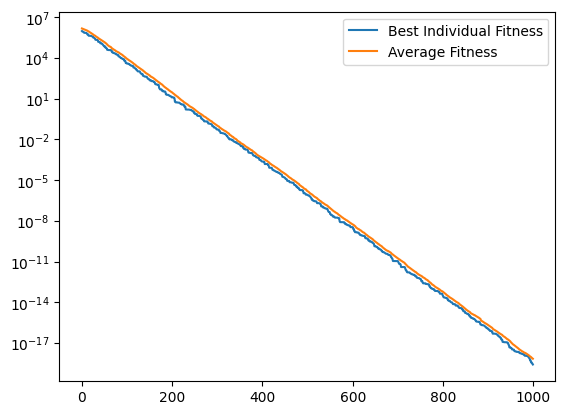

In [61]:
def weighted_sphere(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += (i + 1) * x[i] ** 2
    return cost

for i in range(30):
    np.random.seed(i)
    metric_weighted_sphere = MetricCollector(name="weighted_sphere", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000

    res = differential_evolution(
        f=weighted_sphere,
        differential_factor=0.5,
        bounds=bounds,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_weighted_sphere,
        mutator=rand_1_bin_mutator,
        population_size=40,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0)
    )
    metric_weighted_sphere.save_results()

metric_weighted_sphere.compile_graph()
res

Iteration 0: 53439.59698222557
Iteration 50: 18108.98279703352
Iteration 100: 10018.675553154042
Iteration 150: 10018.675553154042
Iteration 200: 9751.03538126277
Iteration 250: 9625.117584079917
Iteration 300: 9625.117584079917
Iteration 350: 9603.929751427266
Iteration 400: 8145.97362913213
Iteration 450: 8035.045987283118
Iteration 500: 7308.575713189377
Iteration 550: 4666.80366722351
Iteration 600: 4506.917496703207
Iteration 650: 3088.938803365234
Iteration 700: 3088.938803365234
Iteration 750: 2805.983674147784
Iteration 800: 2475.457202087494
Iteration 850: 2409.2251453491335
Iteration 900: 2409.2251453491335
Iteration 950: 2074.4326856719827
Iteration 0: 53439.59698222557
Iteration 50: 18056.537799514368
Iteration 100: 11794.649074960204
Iteration 150: 8363.400622099787
Iteration 200: 6112.968080080029
Iteration 250: 5982.6385569420345
Iteration 300: 5966.963832865494
Iteration 350: 4829.7360526448165
Iteration 400: 4472.701730247765
Iteration 450: 4472.701730247765
Iteration 

(array([ 11.06609029,   0.79009862, -14.08255255,  10.97664152,
        -11.89613263,  -0.93297222,  18.07773956, -13.03234556,
        -10.69625017,  -6.33295636,  25.89838798,  -9.77506781,
          7.39352033, -20.19148625,   7.2832757 ,   1.44297891,
         18.09995854, -13.68908874,  -5.07079518,   5.05415011,
          8.36028796,  -3.28038919, -13.19945953,   2.1228655 ,
          2.06739885,   0.29300759,  17.44334542, -10.0767272 ,
         -5.94812757,   3.97161999]),
 1948.7009731424807)

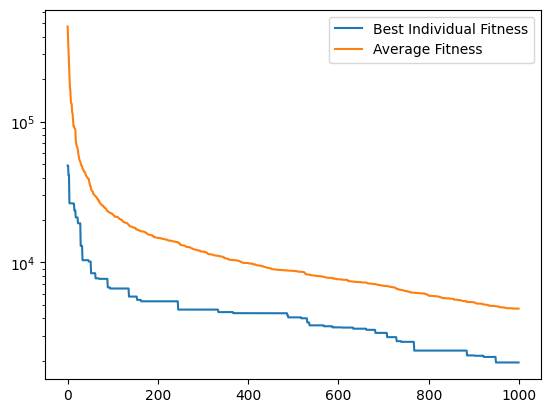

In [62]:
def schwefel_1_2(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(np.apply_along_axis(lambda y: y, 0, x[:i+1])) ** 2
    return cost


for i in range(30):
    np.random.seed(i)
    metric_schwefel_1_2 = MetricCollector(name="schwefel_1_2", run_id=i)
    bounds = [(-65.536, 65.536) for _ in range(30)]
    d = 30
    n_iters = 1000
    res = differential_evolution(
        f=schwefel_1_2,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0),
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_schwefel_1_2,
        mutator=rand_1_bin_mutator,
        population_size=40
    )
    metric_schwefel_1_2.save_results()

metric_schwefel_1_2.compile_graph()
res

Iteration 0: 3110593.940493743
Iteration 50: 1633211.1915611106
Iteration 100: 1169823.8834280982
Iteration 150: 886661.5920294183
Iteration 200: 851886.004672822
Iteration 250: 771290.0663202719
Iteration 300: 769872.0047183136
Iteration 350: 697431.6394836607
Iteration 400: 678993.120363917
Iteration 450: 678993.120363917
Iteration 500: 647900.3430105555
Iteration 550: 581069.9603979272
Iteration 600: 581069.9603979272
Iteration 650: 554210.0254723037
Iteration 700: 541564.7968103685
Iteration 750: 488653.19702218287
Iteration 800: 488653.19702218287
Iteration 850: 488653.19702218287
Iteration 900: 485123.07465115195
Iteration 950: 485123.07465115195
Iteration 0: 3110593.940493743
Iteration 50: 1389027.7989646005
Iteration 100: 1202696.4089769658
Iteration 150: 1139426.200621389
Iteration 200: 947324.658514216
Iteration 250: 919063.0651895993
Iteration 300: 918852.5764620268
Iteration 350: 720132.0715702508
Iteration 400: 716964.846920758
Iteration 450: 716964.846920758
Iteration 500

(array([   4.88953145,  -37.91433768,  -73.02306685,  377.43191665,
        -154.11669739, -296.06612932,  152.18425839,   70.998911  ,
         100.01434146, -131.83947497, -181.95192401,  349.8498023 ,
        -148.15702726,   -9.22583034, -141.14122914,   -6.3292313 ,
         409.75527895, -329.16607957,  267.36234936, -330.34963458,
          24.03372792,  125.12645086, -305.88390474,  281.59989703,
          44.46832841, -156.73291646,  113.55150375,  -24.49147376,
          18.93239567,  -10.98401167]),
 484192.99916579603)

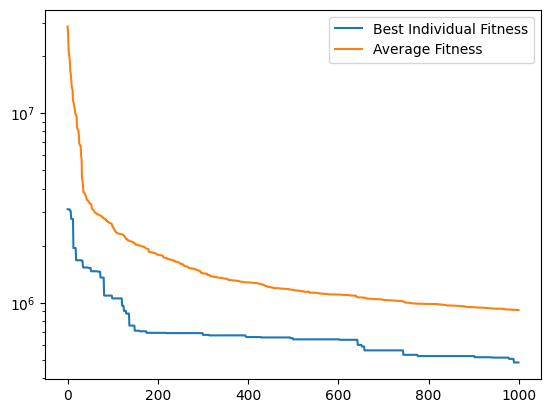

In [63]:
def schwefel_2_3(x: np.ndarray):
    cost = 418.9829 * x.shape[0] - np.sum(np.apply_along_axis(lambda y: y * np.sin(np.sqrt(np.abs(y))), 0, x))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_schwefel_2_3 = MetricCollector(name="schwefel_2_3", run_id=i)
    d = 30
    bounds = [(-500, 500) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = differential_evolution(
        f=schwefel_1_2,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0),
        bounds=bounds,
        differential_factor=1,
        crossover_prob=0.05,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_schwefel_2_3,
        mutator=rand_1_bin_mutator,
        population_size=40
    )
    metric_schwefel_2_3.save_results()
metric_schwefel_2_3.compile_graph()
res

In [12]:
for i in range(30):
    easom = lambda x: bf.Easom()(x) + 1
    np.random.seed(i)
    metric_easom = MetricCollector(name="easom", run_id=i)
    d = 2
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)

    res = differential_evolution(
        f=easom,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0),
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_easom,
        mutator=rand_1_bin_mutator,
        population_size=40
    )
    metric_easom.save_results()
metric_easom.compile_graph()
res

Iteration 0: 1.0
Iteration 50: 0.8593083028931711
Iteration 100: 0.8593083028931711
Iteration 150: 0.03964415420048073
Iteration 200: 3.22741833258533e-13
Iteration 250: 0.0
Iteration 300: 0.0
Iteration 350: 0.0
Iteration 400: 0.0
Iteration 450: 0.0
Iteration 500: 0.0
Iteration 550: 0.0
Iteration 600: 0.0
Iteration 650: 0.0
Iteration 700: 0.0
Iteration 750: 0.0
Iteration 800: 0.0
Iteration 850: 0.0
Iteration 900: 0.0
Iteration 950: 0.0
Iteration 0: 1.0
Iteration 50: 0.9999938635409066
Iteration 100: 0.4441025606484288
Iteration 150: 0.15154099086953565
Iteration 200: 1.8861316679608109e-06
Iteration 250: 0.0
Iteration 300: 0.0
Iteration 350: 0.0
Iteration 400: 0.0
Iteration 450: 0.0
Iteration 500: 0.0
Iteration 550: 0.0
Iteration 600: 0.0
Iteration 650: 0.0
Iteration 700: 0.0
Iteration 750: 0.0
Iteration 800: 0.0
Iteration 850: 0.0
Iteration 900: 0.0
Iteration 950: 0.0
Iteration 0: 1.0
Iteration 50: 0.9999616927947004
Iteration 100: 0.1769264804052345
Iteration 150: 0.01107000146218906

KeyboardInterrupt: 

In [7]:

def rotated_hyper_ellipsoid(x: np.ndarray):
    # rotated hyper ellipsoid
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x[:i+1]))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_rotated_hyper_ellipsoid = MetricCollector(name="rotated_hyper_ellipsoid", run_id=i)
    bounds = [(-65.536, 65.536) for _ in range(30)]
    d = 30
    n_iters = 1000
    res = differential_evolution(
        f=rotated_hyper_ellipsoid,
        initial_pop=latin_hyper_cube_initializer(d, 40, bounds, 0),
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.1,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_rotated_hyper_ellipsoid,
        mutator=rand_1_bin_mutator,
        population_size=40
    )
    metric_rotated_hyper_ellipsoid.save_results()

metric_rotated_hyper_ellipsoid.compile_graph()
res

Iteration 0: 458709.73750415025
Iteration 50: 37150.387863907534
Iteration 100: 2160.715450835831
Iteration 150: 151.49697859574977
Iteration 200: 9.60606660750841
Iteration 250: 0.6199646504991722
Iteration 300: 0.0294102699872237
Iteration 350: 0.0029644588658540613
Iteration 400: 0.00017750780590709714
Iteration 450: 7.607463356899026e-06
Iteration 500: 5.789860423363673e-07
Iteration 550: 3.540140381269808e-08
Iteration 600: 1.4240736630341582e-09
Iteration 650: 9.546770963023008e-11
Iteration 700: 5.707676101585882e-12
Iteration 750: 3.8558124471539214e-13
Iteration 800: 2.3510124267645907e-14
Iteration 850: 1.3242006198140947e-15
Iteration 900: 6.79154079305903e-17
Iteration 950: 5.209493643756959e-18
Iteration 0: 458709.73750415025
Iteration 50: 39650.0058868372
Iteration 100: 2424.8970405691202
Iteration 150: 141.3003816590226


KeyboardInterrupt: 

Iteration 0: 7400.86336825752
Iteration 50: 822.6581249087568
Iteration 100: 211.46839626342327
Iteration 150: 117.75718973545935
Iteration 200: 77.99126346379767
Iteration 250: 37.81142917898649
Iteration 300: 31.01141917198681
Iteration 350: 28.59107384260401
Iteration 400: 27.643012936262433
Iteration 450: 27.2661374318022
Iteration 500: 27.105418319062785
Iteration 550: 27.047462145602186
Iteration 600: 27.013968665435826
Iteration 650: 26.969756410430307
Iteration 700: 26.934364579173916
Iteration 750: 26.91185664192789
Iteration 800: 26.88398821881207
Iteration 850: 26.864024717271704
Iteration 900: 26.839768638515416
Iteration 950: 26.687704198388634
Iteration 0: 7400.86336825752
Iteration 50: 865.1820861252156
Iteration 100: 201.35906327779543
Iteration 150: 98.88371151406614
Iteration 200: 42.17615017023805
Iteration 250: 34.39678078013437
Iteration 300: 29.100833965146247
Iteration 350: 27.62212101190705
Iteration 400: 27.131064230612875
Iteration 450: 26.581445846349045
Iter

(array([6.75554265e-01, 4.72683689e-01, 2.33112737e-01, 6.09609914e-02,
        1.34390695e-02, 1.02604271e-02, 1.04617960e-02, 1.02287719e-02,
        1.02235023e-02, 1.01142331e-02, 1.01923188e-02, 1.03371498e-02,
        1.02000845e-02, 1.02117432e-02, 1.02437184e-02, 1.02021409e-02,
        1.01272525e-02, 1.02130607e-02, 1.03039953e-02, 1.02069002e-02,
        1.01914475e-02, 1.01542702e-02, 1.02242687e-02, 1.01905458e-02,
        1.02268432e-02, 1.02233645e-02, 1.02375712e-02, 1.02200579e-02,
        9.97232878e-03, 9.11462689e-05]),
 26.633730853266613)

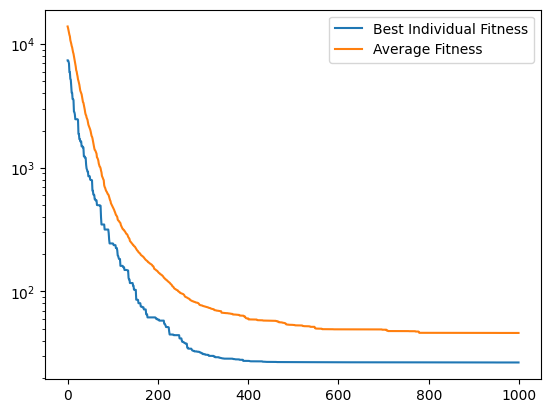

In [65]:
def rosenbrock(x: np.ndarray):
    # rosenbrock
    cost = 0
    for i in range(x.shape[0] - 1):
        cost += 100 * (x[i + 1] - x[i]**2)**2 + (x[i] - 1)**2
    return cost

for i in range(30):
    np.random.seed(i)
    metric_rosen = MetricCollector(name=f"rosenbrock", run_id=i)
    bounds = [(-2.048, 2.048) for _ in range(30)]
    d = 30
    n_iters = 1000
    popsize=40
    res = differential_evolution(
        f=rosenbrock,
        population_size=popsize,
        initial_pop=latin_hyper_cube_initializer(d, popsize, bounds, 0),
        bounds=bounds,
        mutator=rand_1_bin_mutator,
        differential_factor=0.5,
        crossover_prob=0.05,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_rosen
    )
    metric_rosen.save_results()
metric_rosen.compile_graph()
res

Iteration 0: 591.9422542313703
Iteration 50: 44.603315980273265
Iteration 100: 3.6032132073742598
Iteration 150: 1.1577727279211185
Iteration 200: 0.8649139449433443
Iteration 250: 0.13761562390255455
Iteration 300: 0.013085932808716172
Iteration 350: 0.0007235233901923266
Iteration 400: 6.270136853414598e-05
Iteration 450: 4.6709944898637445e-06
Iteration 500: 2.419891005356334e-07
Iteration 550: 1.7990909650933418e-08
Iteration 600: 1.30474608894815e-09
Iteration 650: 1.0454104248935892e-10
Iteration 700: 5.5112581165417396e-12
Iteration 750: 2.6545432518787493e-13
Iteration 800: 1.354472090042691e-14
Iteration 850: 6.661338147750939e-16
Iteration 900: 0.0
Iteration 950: 0.0
Iteration 0: 591.9422542313703
Iteration 50: 38.19758205088884
Iteration 100: 3.0384861303784994
Iteration 150: 1.1169086050120294
Iteration 200: 0.8436321627346497
Iteration 250: 0.24570120380765614
Iteration 300: 0.046575054099795454
Iteration 350: 0.010965467311813248
Iteration 400: 0.007943973349030298
Iterat

(array([ 3.14002259e+00, -4.05950937e-09,  6.99517645e-09, -5.56082405e-09,
         7.00729629e+00, -8.96462476e-09, -9.13273392e-09, -2.56516088e-08,
         2.42393962e-08,  3.24027387e-08,  1.92117106e-08,  3.01943369e-08,
         9.29843471e-09,  3.17909805e-08,  3.05647140e-08,  5.88425280e-09,
         4.24712422e-08, -1.63987862e-08,  8.02176918e-09,  3.55975802e-08,
        -9.54313038e-09,  1.83512490e-08,  2.90852341e-08,  3.68627846e-08,
        -1.07857904e-08,  3.14532917e-08, -4.20157999e-08,  1.43701352e-09,
        -1.29193078e-08, -5.75778017e-09]),
 0.014772407722822956)

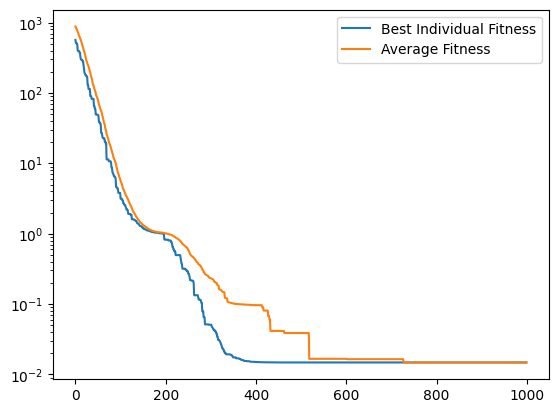

In [66]:
def griewangk(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

for i in range(30):
    np.random.seed(i)
    metric_griewangk = MetricCollector(name=f"griewangk", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    popsize=40
    n_iters=1000
    res = differential_evolution(
        f=griewangk,
        initial_pop=latin_hyper_cube_initializer(d, popsize, bounds, 0),
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.1,
        mutator=rand_1_bin_mutator,
        crossover_func=binomial_crossover,
        population_size=40,
        n_iter=n_iters,
        metric=metric_griewangk
    )

    metric_griewangk.save_results()

metric_griewangk.compile_graph()
res

Iteration 0: 1.1535730904427648
Iteration 50: 0.00442838845075966
Iteration 100: 1.0233168213634105e-06
Iteration 150: 3.641718212025659e-08
Iteration 200: 1.6182616991843647e-10
Iteration 250: 4.70937574298463e-13
Iteration 300: 5.34568364901884e-15
Iteration 350: 2.2215556449213453e-17
Iteration 400: 2.695430648665674e-19
Iteration 450: 5.36508044823248e-21
Iteration 500: 8.064759142896071e-23
Iteration 550: 1.960558078206205e-24
Iteration 600: 1.1578164973605e-26
Iteration 650: 1.7198167180391597e-28
Iteration 700: 3.5332701401241633e-31
Iteration 750: 9.275004981435923e-34
Iteration 800: 2.4875199400138204e-35
Iteration 850: 7.040312993112504e-37
Iteration 900: 4.0710879769697146e-39
Iteration 950: 2.5677667928972764e-41


(array([ 9.21646791e-44,  1.02537788e-22,  5.10136729e-17, -3.18315297e-12,
        -1.42938735e-09, -6.17099841e-09,  4.73165667e-07, -2.88518547e-06,
        -7.30086191e-06,  1.43889233e-06, -7.89099496e-05,  2.06288517e-04,
         4.94875174e-04,  4.33488978e-04, -8.05017693e-04, -7.82595771e-04,
         2.94395099e-03, -3.37048805e-03,  2.41556336e-03, -3.26344185e-03,
        -7.99784224e-03, -6.81129352e-03,  5.15513409e-03, -1.42703597e-02,
         4.71023062e-03,  1.68940421e-02, -2.64140245e-02, -2.32576460e-04,
        -1.65844453e-02,  3.71359366e-02]),
 7.129485285997747e-43)

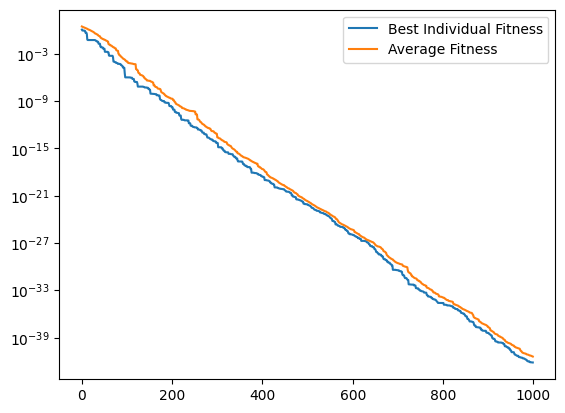

In [14]:
def pow_sum(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

for i in range(1):
    np.random.seed(i)
    metric_pow_sum = MetricCollector(name=f"pow_sum", run_id=i)
    d = 30
    bounds = [(-1, 1) for _ in range(d)]
    popsize=40
    n_iters=1000
    res = differential_evolution(
        f=pow_sum,
        initial_pop=latin_hyper_cube_initializer(d, popsize, bounds, 0),
        differential_factor=0.5,
        bounds=bounds,
        crossover_prob=0.1,
        mutator=rand_1_bin_mutator,
        crossover_func=binomial_crossover,
        population_size=popsize,
        n_iter=n_iters,
        metric=metric_pow_sum
    )

    metric_pow_sum.save_results()

metric_pow_sum.compile_graph()
res

Iteration 0: 20.739353060582147
Iteration 50: 13.007098065961014
Iteration 100: 6.226172252289587
Iteration 150: 3.056972901835295
Iteration 200: 0.7856328780987138
Iteration 250: 0.10269120711202051
Iteration 300: 0.022230094434928294
Iteration 350: 0.0044834941757057045
Iteration 400: 0.001103935709843018
Iteration 450: 0.0003238442796313912
Iteration 500: 8.152007160022734e-05
Iteration 550: 2.0806209221735372e-05
Iteration 600: 4.457062946716661e-06
Iteration 650: 1.2924887582421718e-06
Iteration 700: 3.036934441702499e-07
Iteration 750: 6.551951203803696e-08
Iteration 800: 1.4914438128954544e-08
Iteration 850: 3.3708400515308767e-09
Iteration 900: 9.423613001047215e-10
Iteration 950: 2.2606316818496452e-10
Iteration 0: 20.739353060582147
Iteration 50: 14.676826662771209
Iteration 100: 6.346188308074996
Iteration 150: 2.772862724386297
Iteration 200: 0.5790562319227779
Iteration 250: 0.08215955847932621
Iteration 300: 0.01728448758162715
Iteration 350: 0.0037535727157131937
Iterati

(array([-1.00522906e-11,  7.47609243e-12,  7.28341877e-12, -1.17251486e-12,
         6.66068667e-13, -5.26813224e-12,  2.57318934e-11,  6.69843339e-12,
        -4.00988114e-12, -1.06504828e-11, -3.45736674e-13,  1.27679269e-11,
         1.27214253e-11,  7.81846597e-14,  1.17415875e-11, -2.15948576e-12,
        -1.21545616e-11,  2.16020305e-11, -7.31032832e-12,  1.92988424e-11,
         3.92952219e-12, -4.15258497e-13,  1.96036270e-11,  9.66128182e-12,
        -1.19202222e-11,  1.00201644e-11,  9.88761854e-12,  1.14802277e-12,
         1.62684534e-11,  4.79753584e-12]),
 4.445910306571932e-11)

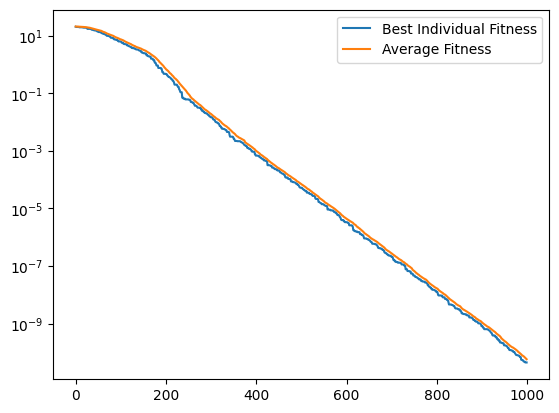

In [68]:
def ack(x: np.ndarray):
    # ackley function
    cost = -20 * np.exp(-0.2 * np.sqrt(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: y**2, 0, x)))) - np.exp(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: np.cos(2 * np.pi * y), 0, x))) + 20 + np.exp(1)
    return cost

for i in range(30):
    metric_ack = MetricCollector(name=f"ackley", run_id=i)
    d = 30
    bounds = [(-32.768, 32.768) for _ in range(d)]
    population_size = 40
    init_population = latin_hyper_cube_initializer(d, population_size, bounds, 0)
    res = differential_evolution(
        f=ack,
        initial_pop=init_population,
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.1,
        mutator=rand_1_bin_mutator,
        crossover_func=binomial_crossover,
        population_size=population_size,
        n_iter=1000,
        metric=metric_ack
    )
    metric_ack.save_results()
metric_ack.compile_graph()
res

Iteration 0: 2364036.723388786
Iteration 50: 770550.3534750835
Iteration 100: 111818.88690551775
Iteration 150: 20766.11954923247
Iteration 200: 2417.0671909606936
Iteration 250: 721.2740245875334
Iteration 300: 310.0225371379684
Iteration 350: 159.14094671298977
Iteration 400: 79.51644637502639
Iteration 450: 51.57931963746128
Iteration 500: 25.42701616699304
Iteration 550: 13.019382221085152
Iteration 600: 5.648337299127945
Iteration 650: 2.6169415545806487
Iteration 700: 0.200472723834082
Iteration 750: 0.021917073069346316
Iteration 800: 0.005213086501214548
Iteration 850: 0.0009473294944086774
Iteration 900: 6.294821366736869e-05
Iteration 950: 1.276872990274569e-05
Iteration 0: 2364036.723388786
Iteration 50: 739916.0799158298
Iteration 100: 128614.67224444651
Iteration 150: 30231.413559440673
Iteration 200: 4013.133061626737
Iteration 250: 760.8912568135497
Iteration 300: 305.9921910104389
Iteration 350: 167.98604106598307
Iteration 400: 92.61858053856469
Iteration 450: 61.05194

(array([-5.66260249e-06,  1.59603523e-06, -8.15493714e-06, -1.91493838e-07,
         1.24734365e-05, -3.43764158e-06, -1.86150883e-05,  2.58839245e-05,
         9.07792642e-06,  2.48948629e-05, -6.33322927e-05, -1.39749716e-05,
        -3.61968285e-05,  4.28894872e-07, -6.39278020e-05, -2.80858764e-05,
         1.68901960e-05,  2.38183985e-05, -7.30441457e-06, -1.76314155e-05,
        -5.80188148e-05,  3.02984740e-05, -8.93587374e-06, -7.36356586e-06,
        -2.07637132e-05, -1.16334422e-08, -2.96081215e-06,  1.11190851e-06,
        -1.38782199e-05, -2.29895152e-06]),
 3.700719673815911e-06)

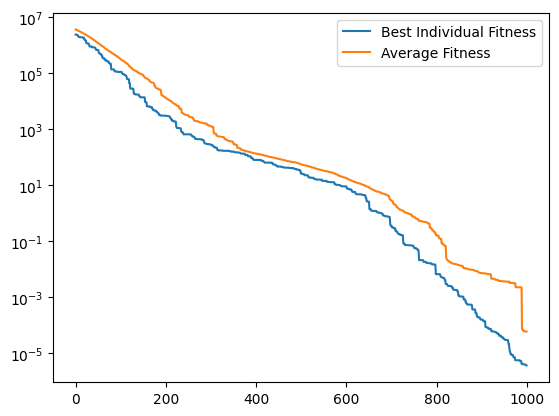

In [10]:
def rastrigin(x: np.ndarray):
    return 10 * x.shape[0] + np.sum(np.apply_along_axis(lambda y: y**2 - 10 * np.cos(2 * np.pi * y), 0, x))
for i in range(30):
    np.random.seed(i)
    metric_ras = MetricCollector(name=f"rastrigin", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    population_size = 40
    init_population = latin_hyper_cube_initializer(d, population_size, bounds, 0)
    res = differential_evolution(
        f=rastrigin,
        initial_pop=init_population,
        bounds=bounds,
        differential_factor=0.5,
        crossover_prob=0.0,
        mutator=rand_1_bin_mutator,
        crossover_func=binomial_crossover,
        population_size=population_size,
        n_iter=1000,
        metric=metric_ras
    )
    metric_ras.save_results()
metric_ras.compile_graph()
res

In [70]:
# opt.differential_evolution(
#     func=rotated_hyper_ellipsoid,
#     popsize=40,
#     bounds=[(-600, 600) for _ in range(20)],
#     maxiter=1000,
#     disp=True,
#     strategy="rand1bin",
#     recombination=0,
#     mutation=0.5,
#     polish=False
# )

Iteration 0: 33.130643968857505
Iteration 50: 0.9980038377944496
Iteration 100: 0.9980038377944496
Iteration 150: 0.9980038377944496
Iteration 200: 0.9980038377944496
Iteration 250: 0.9980038377944496
Iteration 300: 0.9980038377944496
Iteration 350: 0.9980038377944496
Iteration 400: 0.9980038377944496
Iteration 450: 0.9980038377944496
Iteration 500: 0.9980038377944496
Iteration 550: 0.9980038377944496
Iteration 600: 0.9980038377944496
Iteration 650: 0.9980038377944496
Iteration 700: 0.9980038377944496
Iteration 750: 0.9980038377944496
Iteration 800: 0.9980038377944496
Iteration 850: 0.9980038377944496
Iteration 900: 0.9980038377944496
Iteration 950: 0.9980038377944493
Iteration 0: 33.130643968857505
Iteration 50: 0.9980038377944498
Iteration 100: 0.9980038377944496
Iteration 150: 0.9980038377944496
Iteration 200: 0.9980038377944496
Iteration 250: 0.9980038377944496
Iteration 300: 0.9980038377944496
Iteration 350: 0.9980038377944496
Iteration 400: 0.9980038377944496
Iteration 450: 0.998

(array([-31.97833371, -31.97833487]), 0.9980038377944496)

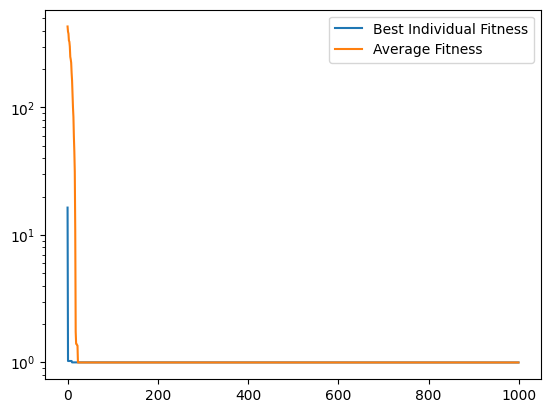

In [71]:
for i in range(30):
    metric_dejong_5 = MetricCollector(name=f"dejong_5", run_id=i)
    funcs = bf.DeJong5()
    bounds = [(-65.536, 65.636), (-65.536, 65.636)]
    n_iters=1000
    res = differential_evolution(
        f=funcs,
        population_size=40,
        bounds=bounds,
        initial_pop=latin_hyper_cube_initializer(2, 40, bounds, 0),
        differential_factor=0.5,
        crossover_prob=0.0,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_dejong_5,
        mutator=rand_1_bin_mutator,
        vtr=0.999
    )
    metric_dejong_5.save_results()
metric_dejong_5.compile_graph()
res

Iteration 0: 79
Iteration 50: 48
Iteration 100: 20
Iteration 150: 9
Iteration 200: 3
Iteration 250: 0
Iteration 300: 0
Iteration 350: 0
Iteration 400: 0
Iteration 450: 0
Iteration 500: 0
Iteration 550: 0
Iteration 600: 0
Iteration 650: 0
Iteration 700: 0
Iteration 750: 0
Iteration 800: 0
Iteration 850: 0
Iteration 900: 0
Iteration 950: 0
Iteration 0: 79
Iteration 50: 46
Iteration 100: 21
Iteration 150: 11
Iteration 200: 4
Iteration 250: 0
Iteration 300: 0
Iteration 350: 0
Iteration 400: 0
Iteration 450: 0
Iteration 500: 0
Iteration 550: 0
Iteration 600: 0
Iteration 650: 0
Iteration 700: 0
Iteration 750: 0
Iteration 800: 0
Iteration 850: 0
Iteration 900: 0
Iteration 950: 0
Iteration 0: 79
Iteration 50: 39
Iteration 100: 23
Iteration 150: 8
Iteration 200: 2
Iteration 250: 0
Iteration 300: 0
Iteration 350: 0
Iteration 400: 0
Iteration 450: 0
Iteration 500: 0
Iteration 550: 0
Iteration 600: 0
Iteration 650: 0
Iteration 700: 0
Iteration 750: 0
Iteration 800: 0
Iteration 850: 0
Iteration 900

(array([-3.27522655, -3.24028564, -3.29556145, -3.03963724, -3.23285398,
        -3.26147493, -3.39089709, -3.25705068, -3.34980825, -3.24316134,
        -3.1988697 , -3.46015778, -3.2441182 , -3.3414232 , -3.08238657,
        -3.2660036 , -3.46371093, -3.33030989, -3.34273354, -3.14349052,
        -3.11590216, -3.06864435, -3.17385196, -3.21595845, -3.40053957,
        -3.29254684, -3.45756576, -3.48388418, -3.24844319, -3.33212225]),
 0)

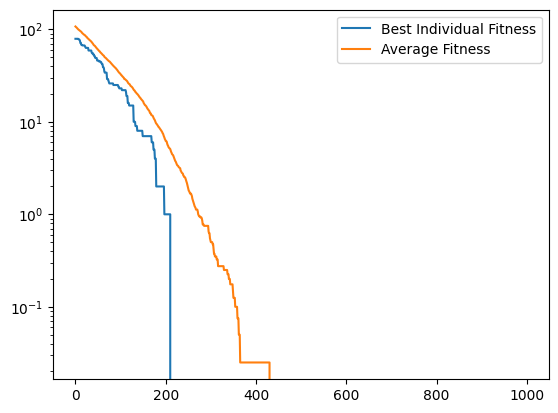

In [72]:
for i in range(30):
    np.random.seed(i)
    dejong_3_func = lambda x: bf.DeJong3(n_dimensions=30)(x) + 120
    metric_dejong_3 = MetricCollector(name=f"dejong_3", run_id=i)
    bounds = [(-3.5, 3.8) for i in range(30)]
    n_iters=1000
    res = differential_evolution(
        f=dejong_3_func,
        population_size=40,
        bounds=bounds,
        initial_pop=latin_hyper_cube_initializer(30, 40, bounds, 0),
        differential_factor=0.5,
        crossover_prob=0.0,
        crossover_func=binomial_crossover,
        n_iter=n_iters,
        metric=metric_dejong_3,
        mutator=rand_1_bin_mutator
    )
    metric_dejong_3.save_results()
metric_dejong_3.compile_graph()
res